<a href="https://colab.research.google.com/github/KBM5703/BTL_ML-APP_HK242_NHOM7/blob/main/SLDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe==0.10.9 opencv-python numpy scikit-learn tensorflow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [3]:
import zipfile
import os

zip_path = '/content/dataset.zip'  # thay bằng tên file bạn upload
extract_folder = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
from mediapipe.python.solutions import hands as mp_hands
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
def extract_hand_keypoints(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Lỗi đọc ảnh: {image_path}")
        return np.zeros(63)  # 21 điểm x,y,z = 63 giá trị

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        hand_landmarks = result.multi_hand_landmarks[0]
        keypoints = []
        for lm in hand_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
        return np.array(keypoints)
    else:
        return np.zeros(63)


In [9]:
def load_dataset_with_subfolders(folder_path):
    X = []
    Y = []

    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue

        for img_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_file)
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            keypoints = extract_hand_keypoints(img_path)
            X.append(keypoints)
            Y.append(label_name)  # label lấy tên folder luôn

    return np.array(X), np.array(Y)


In [11]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

X_train, Y_train = load_dataset_with_subfolders(train_dir)
X_test, Y_test = load_dataset_with_subfolders(test_dir)

print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)


Train shape: (1512, 63) (1512,)
Test shape: (72, 63) (72,)


In [12]:
encoder = LabelEncoder()
Y_train_encoded = encoder.fit_transform(Y_train)
Y_test_encoded = encoder.transform(Y_test)

print("Các nhãn đã mã hóa:", encoder.classes_)


Các nhãn đã mã hóa: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [13]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(63,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')  # số lượng lớp
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,138 (70.85 KB)

 Trainable params: 18,138 (70.85 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, Y_train_encoded,
    epochs=50,
    validation_data=(X_test, Y_test_encoded),
    batch_size=32
)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.0428 - loss: 3.2728 - val_accuracy: 0.0556 - val_loss: 3.2241
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0704 - loss: 3.2197 - val_accuracy: 0.0833 - val_loss: 3.1911
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0710 - loss: 3.2146 - val_accuracy: 0.0694 - val_loss: 3.1289
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0819 - loss: 3.1598 - val_accuracy: 0.0833 - val_loss: 3.0544
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1107 - loss: 3.0910 - val_accuracy: 0.0833 - val_loss: 2.9686
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1238 - loss: 3.0073 - val_accuracy: 0.1250 - val_loss: 2.8387
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1528 - loss: 2.9368 - val_accuracy: 0.1250 - val_loss: 2.7309
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1834 - loss: 2.7997 - val_accuracy: 0.2639 - val_loss

In [16]:
model.save('sign_language_model.keras')


In [18]:
from google.colab import files
files.download('/content/sign_language_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

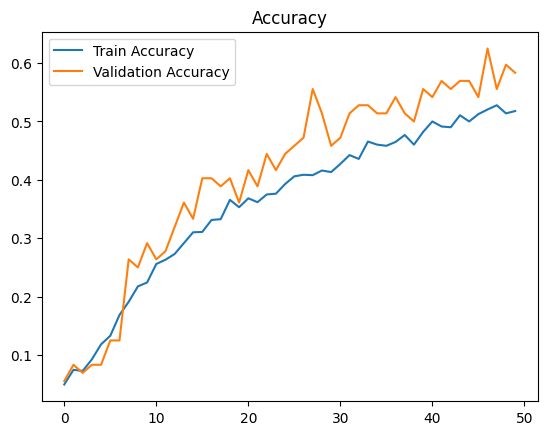

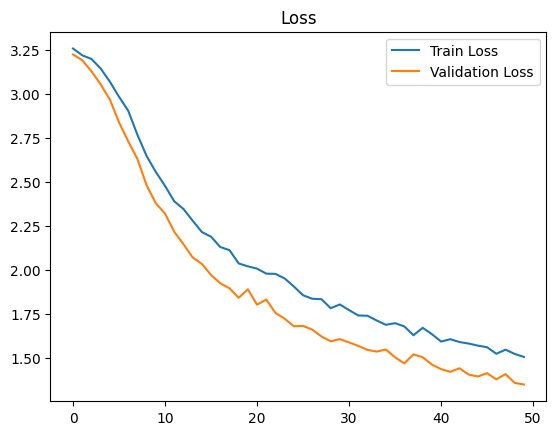

In [19]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [24]:
import matplotlib.pyplot as plt


# Vẽ và lưu biểu đồ Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('/content/loss_plot.png')  # lưu file ảnh
plt.close()


In [26]:
from google.colab import files
files.download('/content/loss_plot.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!git --version


git version 2.34.1


In [28]:
!git clone https://github.com/KBM5703/BTL_ML-APP_HK242_NHOM7


Cloning into 'BTL_ML-APP_HK242_NHOM7'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [29]:
!cp /content/SignLanguage_Train.ipynb /content/BTL_ML-APP_HK242_NHOM7/
!cp /content/sign_language_model.h5 /content/BTL_ML-APP_HK242_NHOM7/
!cp /content/main.py /content/BTL_ML-APP_HK242_NHOM7/
!cp -r /content/dataset /content/BTL_ML-APP_HK242_NHOM7/


cp: cannot stat '/content/SignLanguage_Train.ipynb': No such file or directory
cp: cannot stat '/content/main.py': No such file or directory
